## Sales Demand Forecasting


[Wikipedia](https://en.wikipedia.org/wiki/Forecasting) defines Forecasting as the process of making predictions of the future based on past and present data and most commonly by analysis of trends. History is filled with people making predictions by looking at trends and drawing conclusions from patterns. 

For businesses, the ability to forecast the future and make  informed business decisions is critical to their survival.  
Many organizations' traditional methods of generating forecasts from historical data often struggle to generate an accurate prediction from large data and data with irregular trends. 

For eCommerce stores, the ability to predict demand accurately is a critical need.  They need to know how many inventory store units to have at hand to be at full stock for each product at a given time.  A low inventory level increases the risk of having a stock out, and a tool high inventory level increases the cost related to handling inventory.


Recent research shows that [43% of online businesses](https://www.veeqo.com/inventory-management) admitted that they have inventory problems. Retailers have constant pressure to meet market demand. This pressure is exacerbated by the fact that consumers have many options. A customer with unmet demands will not likely return to the same retailer. 



Being able to predict an accurate demand is not limited to small businesses alone. In 2013, Walmart experienced[ out-of-stock across all stores](https://www.rsrresearch.com/research/the-walmart-out-of-stock-problem-lessons-learned). 



The big question stands: can recent advances in machine learning help retailers forecast demand? ML tools' democratization is empowering individuals with little to no ML skills to solve complex problems that previously required strong expertise in ML. AWS Forecast is one of these tools.


In this notebook, you'll learn how to predict sales demand using AWS Forecast. It's important to know that the workflow demonstrated in this notebook from data preprocessing to training a predictor can be fully automated.


### Amazon Forecast 
[Amazon forecast](https://aws.amazon.com/forecast/) is a managed service that uses ML to deliver highly accurate forecasts. It looks at historical data (time series data) to build forecasts. Amazon Forecast abstracts the complexity of training, building, or deploying a model. It automatically examines your data, engineers features, and generates a forecasting model. 

Amazon Forecast works in four (4) simple steps:
- Import training data
- Train a forecast predictor
- Create a forecast
- Retrieve a forecast

Amazon Forecast supports multiple domains. In this example, we'll use the RETAIL domain to predict product demand. 
 

### Dataset

For this tutorial, we will use the public [Olist public e-commerce dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce) to train a predictor.  The dataset can be found in this [repository](https://github.com/abiodunjames/Predicting-ecommerce-sales-forecast).  

In [1]:
# clone the dataset repository
! git clone https://github.com/abiodunjames/Predicting-ecommerce-sales-forecast

Cloning into 'Predicting-ecommerce-sales-forecast'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 1), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), done.




# Data Pre-processing

One important thing to note is you can't just feed any datasets into AWS Forecast. A dataset domain must be specified, and the dataset must conform to the structure of the domain. You can think of a dataset domain as a predefined dataset schema or format for a use case.  For predicting sales demand, the [RETAIL Domain](https://docs.aws.amazon.com/forecast/latest/dg/retail-domain.html) is a perfect choice. 

The Retail Domain must define three required fields, the  `item_id` (string), `timestamp` (timestamp) and the `demand` (float). This means we have to do some data pre-processing. The following code already.
 
`item_id`: (string) – A unique identifier for the item or product that you want to predict the demand for.

`timestamp`: (timestamp)

`demand`: (float) – The number of sales for that item at the timestamp. This is also the target field for which Amazon Forecast generates a forecast.

To work with the RETAIL domain, the dataset has to be pre-processed.

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
orders_file = './Predicting-ecommerce-sales-forecast/data/olist_orders_dataset.csv'
items_file = './Predicting-ecommerce-sales-forecast/data/olist_order_items_dataset.csv'
products_file = './Predicting-ecommerce-sales-forecast/data/olist_products_dataset.csv'
translation_file = './Predicting-ecommerce-sales-forecast/data/product_category_name_translation.csv'

orders_df = pd.read_csv(orders_file)
order_items_df = pd.read_csv(items_file)
products_df = pd.read_csv(products_file)
translation_df = pd.read_csv(translation_file)
# Merge translation file with product so we can get the name of products in English
products_df = products_df.merge(translation_df, on='product_category_name')
#Merge product with order items so that can we put name to each order item.
order_items_df = products_df.merge(order_items_df, on="product_id", how='right')


In [4]:
assert pd.Series(order_items_df['order_id']).is_unique is False
#Merge order items with order dataframe to get the timestamp of the date the order was placed
merged_datasets = orders_df.merge(order_items_df, on="order_id", how='right')
merged_datasets.to_csv("datasets.csv", index=False)
df = pd.read_csv('datasets.csv')
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,product_category_name,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,utilidades_domesticas,...,500.0,19.0,8.0,13.0,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,perfumaria,...,400.0,19.0,13.0,19.0,perfumery,1,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,aa4383b373c6aca5d8797843e5594415,automotivo,...,420.0,24.0,19.0,21.0,auto,1,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,...,450.0,30.0,10.0,20.0,pet_shop,1,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,65266b2da20d04dbe00c5c2d3bb7859e,papelaria,...,250.0,51.0,15.0,15.0,stationery,1,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [5]:
demand_per_time = df.groupby(['order_purchase_timestamp', 'product_category_name'])['order_purchase_timestamp'].count().reset_index(name="demand")
demand_per_time.rename(columns={'order_purchase_timestamp': 'timestamp', 'product_category_name_english': 'item_id'}, inplace=True)
# Convert string timestamp to pandas datetime
demand_per_time['timestamp'] = demand_per_time['timestamp'].astype('datetime64[ns]') 
demand_per_time.head()

,timestamp,product_category_name,demand
0,2016-09-04 21:15:19,moveis_decoracao,2
1,2016-09-05 00:15:34,telefonia,1
2,2016-09-15 12:16:38,beleza_saude,3
3,2016-10-02 22:07:52,bebes,1
4,2016-10-03 09:44:50,relogios_presentes,1


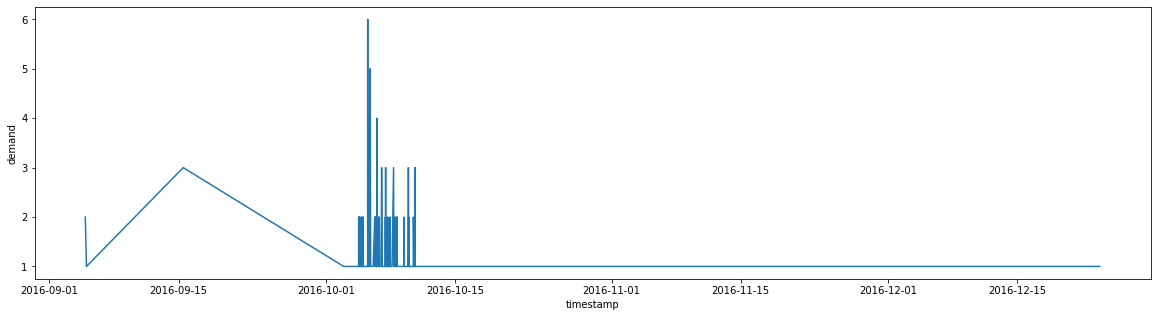

In [6]:
demand_per_time_2016 = demand_per_time[demand_per_time['timestamp'].dt.strftime('%Y')=='2016']
demand_per_time_2016.to_csv('demand_per_time_2016.csv', index=False)
plt.figure(figsize=(20,5))
sns.lineplot(x="timestamp", y="demand", data=demand_per_time_2016)

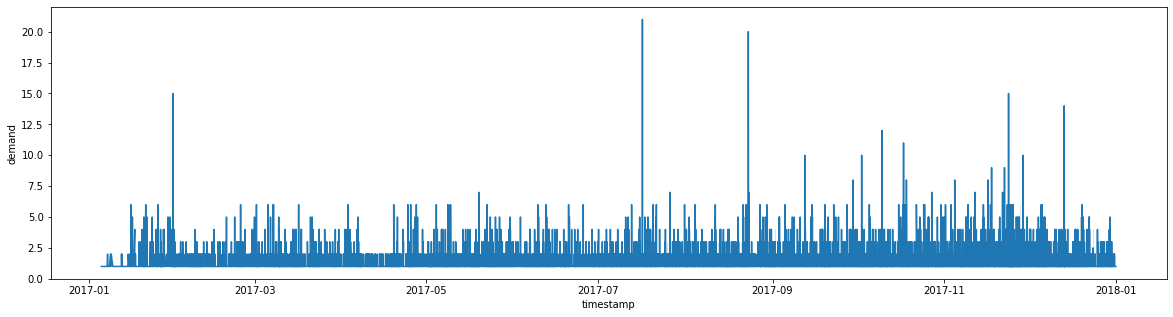

In [7]:
demand_per_time_2017 = demand_per_time[demand_per_time['timestamp'].dt.strftime('%Y')=='2017']
plt.figure(figsize=(20,5))
sns.lineplot(x="timestamp", y="demand", data=demand_per_time_2017)

demand_per_time_2017.to_csv('demand_per_time_2017.csv', index=False)


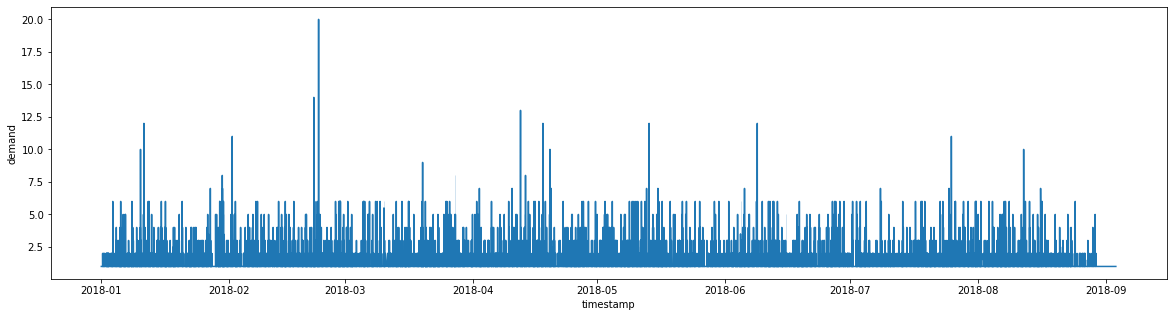

In [8]:
demand_per_time_2018 = demand_per_time[demand_per_time['timestamp'].dt.strftime('%Y')=='2018']
demand_per_time_2018.to_csv('demand_per_time_2018.csv', index=False)

plt.figure(figsize=(20,5))
sns.lineplot(x="timestamp", y="demand", data=demand_per_time_2018)


In [9]:
demand_per_time_2018_and_2017 = demand_per_time[demand_per_time['timestamp'].dt.strftime('%Y')!='2016']
demand_per_time_2018_and_2017.to_csv('demand_per_time_2018_and_2017.csv', index=False)
demand_per_time_2018_and_2017.head()

,timestamp,product_category_name,demand
313,2017-01-05 11:56:06,fashion_bolsas_e_acessorios,1
314,2017-01-05 12:01:20,automotivo,1
315,2017-01-05 12:06:36,pet_shop,1
316,2017-01-05 12:09:08,pet_shop,1
317,2017-01-05 12:11:23,pet_shop,1


# Upload  Processed Dataset To An S3 Bucket


In [2]:
import boto3
import sagemaker
s3 = boto3.client("s3", region_name='us-east-1')
bucket_name='sales-forecast-test-bucket'
bucket = s3.create_bucket(Bucket=bucket_name)

In [11]:
bucket

{'ResponseMetadata': {'RequestId': '2Q5T3H4WCKCP7V2R',
  'HostId': 'aYmse8LUBXM91zvj/X24GeO+QK4VDUFbtlFaF4F9hLDGqVIhoeQVniYxOm5AmWv9sjZrgkszkF0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'aYmse8LUBXM91zvj/X24GeO+QK4VDUFbtlFaF4F9hLDGqVIhoeQVniYxOm5AmWv9sjZrgkszkF0=',
   'x-amz-request-id': '2Q5T3H4WCKCP7V2R',
   'date': 'Wed, 07 Oct 2020 05:56:03 GMT',
   'location': '/sales-forecast-test-bucket',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/sales-forecast-test-bucket'}

In [12]:
s3.upload_file(Filename="demand_per_time_2018_and_2017.csv", Bucket=bucket_name, Key="demand_per_time_2018_and_2017.csv")

We can check through the console to confirm that the bucket was created and the file was uploaded successfully.
> If you're following this guide. You should use a different bucket name


![Uploaded Image](https://res.cloudinary.com/samueljames/image/upload/v1599382424/Screenshot_2020-09-06_at_10.52.33.png)

### Prerequisites
 To continue with this tutorial, you should ensure that the following conditions are met.

- You have an S3 bucket that contains the preprocessed dataset
- Your notebook instance has an IAM role with AmazonForecastFullAccess policy, AmazonSageMakerFullAccess policy,  and S3 Policy with a read and write access to the s3 bucket that contains the preprocessed dataset. 

In [14]:
# Define some variables that will be used in later steps
dataset_group_name = "sales_demand"
dataset_name = "sales_dedataset"
dataset_import_job_name = 'sales_dataset_import_job'
predictor_name = 'sales_predictor'
forecast_name = 'sales_forcast'
forecast_domain = "RETAIL"


In [5]:
role = sagemaker.get_execution_role()
iam = boto3.client('iam')
forecast = boto3.client('forecast', region_name='eu-west-1')

'arn:aws:iam::xxxxxxx:role/SageMakerForecastRole'

## Importing Training Dataset

To import the training dataset, we first need to create a forecast dataset. This will containinformation about the dataset so that AWS Forecast understands how to consume the dataset. We can use Forecast `create_dataset` to achieve this as follows:



In [ ]:
# Create forecast datasets
dataset_response = forecast.create_dataset(
    DatasetName=dataset_name,
    Domain=forecast_domain,
    DatasetType="TARGET_TIME_SERIES",
    DataFrequency="D",
    Schema={
        "Attributes": [
            {"AttributeName": "timestamp", "AttributeType": "timestamp"},
            {"AttributeName": "item_id", "AttributeType": "string"},
            {"AttributeName": "demand", "AttributeType": "float"},
        ]
    },
)
dataset_response

```
{'DatasetArn': 'arn:aws:forecast:eu-west-1:xxxxxxx:dataset/sales_dedataset',
 'ResponseMetadata': {'RequestId': '2e538330-ff75-4c0d-bb1f-2e35af23a64a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 07 Oct 2020 06:37:13 GMT',
   'x-amzn-requestid': '2e538330-ff75-4c0d-bb1f-2e35af23a64a',
   'content-length': '80',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

```

Once the import job succeeded, the next step is to create a forecast using the `create_forecast` api. 

In [34]:
# Create import job
import_job_response = forecast.create_dataset_import_job(
    DatasetImportJobName=dataset_import_job_name,
    DatasetArn=dataset_response["DatasetArn"],
    DataSource={
        "S3Config": {
            "Path": f"s3://{bucket_name}/",
            "RoleArn": role,
        }
    },
    TimestampFormat="yyyy-MM-dd HH:mm:ss", # Timestamp can be  [yyyy-MM-dd, yyyy-MM-dd HH:mm:ss]
)


```
{'DatasetImportJobArn': 'arn:aws:forecast:eu-west-1:XXXXXXX:dataset-import-job/sales_dedataset/sales_dataset_import_job',
 'ResponseMetadata': {'RequestId': '6fffe016-c029-4079-bce5-214f11e523c4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 07 Oct 2020 06:37:15 GMT',
   'x-amzn-requestid': '6fffe016-c029-4079-bce5-214f11e523c4',
   'content-length': '125',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

```

In [ ]:
# Create a dataset group
dataset_group = forecast.create_dataset_group(
    DatasetGroupName=dataset_group_name,
    Domain=forecast_domain,
    DatasetArns=[dataset_response["DatasetArn"]],
)
dataset_group 


```
{'DatasetGroupArn': 'arn:aws:forecast:eu-west-1:XXXXXX:dataset-group/sales_demand',
 'ResponseMetadata': {'RequestId': 'd0f48106-016e-4ea5-9e8c-38dbd3cf9808',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 07 Oct 2020 06:37:16 GMT',
   'x-amzn-requestid': 'd0f48106-016e-4ea5-9e8c-38dbd3cf9808',
   'content-length': '88',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}
```


> Depending on the size of the dataset, the job could take some time to complete. You can execute the cell below to check the status of your job.


In [39]:
import_job_status = forecast.describe_dataset_import_job(
DatasetImportJobArn=import_job_response['DatasetImportJobArn']
)
import_job_status['Status']

'ACTIVE'

Once the import job is active. You should be able to your datasets imported in the console.
![](https://res.cloudinary.com/samueljames/image/upload/v1602053748/Import_Dataset.jpg)

In [40]:
# Create predictor using automl
predictor_response = forecast.create_predictor(
    PredictorName=predictor_name,
    ForecastHorizon=14,
    PerformAutoML=True,
    PerformHPO=False,
    InputDataConfig={"DatasetGroupArn": dataset_group_response["DatasetGroupArn"]},
    FeaturizationConfig={"ForecastFrequency": "D"},
)

predictor_response

```
{'PredictorArn': 'arn:aws:forecast:eu-west-1:XXXXXXX:predictor/sales_predictor',
 'ResponseMetadata': {'RequestId': 'ea30c8d3-9395-4996-8194-49a58d1f90c8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 07 Oct 2020 06:43:33 GMT',
   'x-amzn-requestid': 'ea30c8d3-9395-4996-8194-49a58d1f90c8',
   'content-length': '84',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}
  
```

In [49]:
describe_predictor = forecast.describe_predictor(
    PredictorArn=predictor_response['PredictorArn']
)
describe_predictor['Status']

'ACTIVE'

In [50]:
# Create forecast
forecast_response = forecast.create_forecast(
    ForecastName=forecast_name,
    PredictorArn=predictor_response["PredictorArn"],
    ForecastTypes=["0.1", "0.5", "0.9"],
)

In [54]:
describe_forecast = forecast.describe_forecast(
    ForecastArn=forecast_response['ForecastArn']
)
describe_forecast['Status']

'ACTIVE'

In [57]:
# Create forecast export job
export_job = forecast.create_forecast_export_job(
    ForecastExportJobName="Week2Foecast",
    ForecastArn=forecast_response["ForecastArn"],
    Destination={
        "S3Config": {
            "Path": f's3://{bucket_name}',
            "RoleArn": role,
        }
    },
)

## Clean up

- Delete predictor
- Delete import job
- Delete Dataset
- Delete Dataset Group

In [ ]:
# Delete the predictor
delete_predictor = forecast.delete_predictor(
    PredictorArn=predictor_response['PredictorArn']
)
delete_predictor

In [56]:
# Delete forecast export job
response = forecast.delete_forecast_export_job(
    ForecastExportJobArn=export_job['']
)

In [ ]:
# Delete dataset import job
delete_dataset_import_job = forecast.delete_dataset_import_job(
    DatasetImportJobArn=import_job_response['DatasetImportJobArn']
)
delete_dataset_import_job

In [ ]:
# Delete dataset 
delete_dataset = forecast.delete_dataset(
    DatasetArn=dataset_response['DatasetArn']

 )
delete_dataset

In [ ]:

#Delete dataset group
 delete_dataset_group = forecast.delete_dataset_group(
    DatasetGroupArn=dataset_group_response["DatasetGroupArn"]
)
delete_dataset_group